# OpenVINO™ Explainable AI Toolkit (3/3): Saliency map interpretation

<div class="alert alert-block alert-danger"> <b>Important note:</b> This notebook requires python >= 3.10. Please make sure that your environment fulfill to this requirement before running it </div>

This is the **third notebook** in series of exploring [OpenVINO™ Explainable AI (XAI)](https://github.com/openvinotoolkit/openvino_xai/):

1. [OpenVINO™ Explainable AI Toolkit (1/3): Basic](../explainable-ai-1-basic/README.md)
2. [OpenVINO™ Explainable AI Toolkit (2/3): Deep Dive](../explainable-ai-2-deep-dive/README.md)
3. [**OpenVINO™ Explainable AI Toolkit (3/3): Saliency map interpretation**](../explainable-ai-3-map-interpretation/README.md)

[OpenVINO™ Explainable AI (XAI)](https://github.com/openvinotoolkit/openvino_xai/) provides a suite of XAI algorithms for visual explanation of
[OpenVINO™](https://github.com/openvinotoolkit/openvino) Intermediate Representation (IR) models.

Using **OpenVINO XAI**, you can generate **saliency maps** that highlight regions of interest in input images from the model's perspective. This helps users understand why complex AI models produce specific responses.

This notebook shows how to use saliency maps to evaluate and debug model reasoning.

For example, it might be important to ensure that the model is using relevant features (pixels) to make a correct prediction (e.g., it might be desirable that the model is not relying on X class features to predict Y class). On the other hand, it is valuable to observe which features are used when the model is wrong.

Below, we present examples of saliency map analysis for the following cases: correct and highly-confident prediction, correct and low-confident prediction, and wrong prediction.


#### Table of contents:

- [Prerequisites](#Prerequisites)
    - [Install requirements](#Install-requirements)
    - [Imports](#Imports)
    - [Download dataset](#Download-dataset)
    - [Download IR model](#Download-IR-model)
- [Prepare model to run inference](#Prepare-model-to-run-inference)
    - [Select inference device](#Select-inference-device)
    - [Load the Model](#Load-the-Model)
    - [Define `preprocess_fn`](#Define-preprocess_fn)
- [Explain](#Explain)
    - [Create `Explainer` object](#Create-Explainer-object)
    - [Import ImageNet label names](#Import-ImageNet-label-names)
    - [Explain using ImageNet labels](#Explain-using-ImageNet-labels)
- [Notable use cases in ImageWoof dataset](#Notable-use-cases-in-ImageWoof-dataset)
    - [Explain for each use case](#Explain-for-each-use-case)
    - [Visualize use case saliency maps](#Visualize-use-case-saliency-maps)
    - [Naming logic](#Naming-logic)
- [Results](#Results)
    - [True Positive High confidence](#True-Positive-High-confidence)
    - [True Positive Low confidence](#True-Positive-Low-confidence)
    - [False Positive High confidence](#False-Positive-High-confidence)
    - [Two mixed predictions](#Two-mixed-predictions)

### Installation Instructions

This is a self-contained example that relies solely on its own code.

We recommend  running the notebook in a virtual environment. You only need a Jupyter server to start.
For details, please refer to [Installation Guide](https://github.com/openvinotoolkit/openvino_notebooks/blob/latest/README.md#-installation-guide).

<img referrerpolicy="no-referrer-when-downgrade" src="https://static.scarf.sh/a.png?x-pxid=5b5a4db0-7875-4bfb-bdbd-01698b5b1a77&file=notebooks/explainable-ai-3-map-interpretation/explainable-ai-3-map-interpretation.ipynb" />

## Prerequisites
[back to top ⬆️](#Table-of-contents:)

### Install requirements
[back to top ⬆️](#Table-of-contents:)

In [1]:
%%capture

import platform

# Install openvino package
%pip install -q "openvino>=2024.2.0" opencv-python tqdm

# Install openvino xai package
# %pip install -q --no-deps "openvino-xai>=1.1.0"
%pip install git+https://github.com/negvet/openvino_xai@et/bug_fixing

if platform.system() != "Windows":
    %pip install -q "matplotlib>=3.4"
else:
    %pip install -q "matplotlib>=3.4,<3.7"

### Imports
[back to top ⬆️](#Table-of-contents:)

In [2]:
import os
import zipfile
from pathlib import Path

import cv2
import matplotlib.pyplot as plt
import numpy as np
import requests

import openvino.runtime as ov
import openvino_xai as xai
from openvino_xai.explainer import ExplainMode

# Fetch `notebook_utils` module
r = requests.get(
    url="https://raw.githubusercontent.com/openvinotoolkit/openvino_notebooks/latest/utils/notebook_utils.py",
)

open("notebook_utils.py", "w").write(r.text)

from notebook_utils import download_file, device_widget

### Download dataset
[back to top ⬆️](#Table-of-contents:)

To see examples of saliency maps for different use cases, please download the [ImageWoof dataset](https://huggingface.co/datasets/frgfm/imagewoof) using the code below.

ImageWoof is a subset of 10 classes from ImageNet that are tricky to classify since they're all dog breeds.

In [3]:
base_artifacts_dir = Path("./artifacts").expanduser()
data_folder = base_artifacts_dir / ".data"

In [ ]:
# Download 330 MB of 320 px ImageNet subset with dog breeds
if not (data_folder / "imagewoof320").exists():
    download_file(
        "https://ultralytics.com/assets/imagewoof320.zip",
        directory=data_folder,
    )

    # Define the path to the zip file and the destination directory
    zip_path = data_folder / "imagewoof320.zip"
    extract_dir = data_folder / "imagewoof320"
    with zipfile.ZipFile(zip_path, "r") as zip_ref:
        zip_ref.extractall(extract_dir)

else:
    print(f"Dataset is already downloaded to {base_artifacts_dir} and extracted.")

image_folder_path = data_folder / "imagewoof320" / "imagewoof320"

In [5]:
# Create list of images to explain
img_files = []
img_files.extend(image_folder_path.rglob("*.JPEG"))
print(f"Number of images to get explanations: {len(img_files)}")

# Get a fewer subset for fast execution
np.random.seed(42)
img_files = np.random.choice(img_files, 1)
print(f"Run explanations on fewer number of images: {len(img_files)}")

Number of images to get explanations: 12954
Run explanations on fewer number of images: 1


### Download IR model
[back to top ⬆️](#Table-of-contents:)


In this notebook, for demonstration purposes, we'll use an already converted to IR model `mobilenetv3_large_100.ra_in1k`, from [timm](https://github.com/huggingface/pytorch-image-models) (PyTorch Image Models). This model requires specific preprocessing, including scaling and normalization with certain values.

In [ ]:
model_name = "mobilenetv3_large_100.ra_in1k"
model_xml_name = f"{model_name}.xml"
model_bin_name = f"{model_name}.bin"

model_xml_path = base_artifacts_dir / model_xml_name

base_url = "https://storage.openvinotoolkit.org/repositories/openvino_training_extensions/models/custom_image_classification/"

if not model_xml_path.exists():
    download_file(base_url + model_xml_name, model_xml_name, base_artifacts_dir)
    download_file(base_url + model_bin_name, model_bin_name, base_artifacts_dir)
else:
    print(f"{model_name} already downloaded to {base_artifacts_dir}")

## Prepare model to run inference
[back to top ⬆️](#Table-of-contents:)

### Select inference device
[back to top ⬆️](#Table-of-contents:)

select device from dropdown list for running inference using OpenVINO

In [ ]:
device = device_widget()

device

### Load the Model
[back to top ⬆️](#Table-of-contents:)


In [8]:
core = ov.Core()

model = core.read_model(model=model_xml_path)
compiled_model = core.compile_model(model=model, device_name=device.value)

### Define `preprocess_fn`
[back to top ⬆️](#Table-of-contents:)

This notebook using `WHITEBOX` mode for model explanation - it is required to define function to preprocess data (the alternative is to preprocess input data).
Since the used model is originally from [timm storage](https://github.com/huggingface/pytorch-image-models), it is required to apply specific timm preprocessing, including normalization and scaling with certain values.

In [9]:
def preprocess_fn(x: np.ndarray) -> np.ndarray:
    """
    Implementing own pre-process function based on model's implementation
    """
    x = cv2.resize(src=x, dsize=(224, 224))

    #  Specific normalization for timm model
    mean = np.array([123.675, 116.28, 103.53])
    std = np.array([58.395, 57.12, 57.375])
    x = (x - std) / mean

    # Reshape to model input shape to [channels, height, width].
    x = x.transpose((2, 0, 1))

    # Add batch dimension
    x = np.expand_dims(x, 0)
    return x

## Explain
[back to top ⬆️](#Table-of-contents:)


### Create `Explainer` object
[back to top ⬆️](#Table-of-contents:)

The `Explainer` object can internally apply pre-processing during model inference, allowing raw images as input.
To enable this, define `preprocess_fn` and provide it to the explainer constructor.
If `preprocess_fn` is not defined, it is assumed that the input is preprocessed.

In [10]:
# Create ov.Model
model = core.read_model(model=model_xml_path)

# Create explainer object
explainer = xai.Explainer(
    model=model,
    task=xai.Task.CLASSIFICATION,
    preprocess_fn=preprocess_fn,
    explain_mode=ExplainMode.WHITEBOX,
)

INFO:openvino_xai:Target insertion layer is not provided - trying to find it in auto mode.
INFO:openvino_xai:Using ReciproCAM method (for CNNs).
INFO:openvino_xai:Explaining the model in white-box mode.


### Import ImageNet label names 
[back to top ⬆️](#Table-of-contents:)

If `label_names` are not provided to the explainer call, the saved saliency map will have the predicted class index, not the name. For example, `167.jpg` instead of `English_foxhound.jpg`.

To conveniently view label names in saliency maps, we prepare and provide ImageNet label names information to the explanation call.

In [11]:
%%capture
imagenet_filename = download_file(
    "https://storage.openvinotoolkit.org/repositories/openvino_notebooks/data/data/datasets/imagenet/imagenet_2012.txt",
    directory=".data",
)

imagenet_classes = imagenet_filename.read_text().splitlines()

In [12]:
# Get ImageNet label names to add them to explanations
imagenet_labels = []
for label in imagenet_classes:
    class_label = " ".join(label.split(" ")[1:])
    first_class_label = class_label.split(",")[0].replace(" ", "_")
    imagenet_labels.append(first_class_label)

# Check, how dog breed labels will look in saved saliency map names
dog_breeds_indices = [155, 159, 162, 167, 193, 207, 229, 258, 273]
print(" ".join([imagenet_labels[ind] for ind in dog_breeds_indices]))

Shih-Tzu Rhodesian_ridgeback beagle English_foxhound Australian_terrier golden_retriever Old_English_sheepdog Samoyed dingo


### Explain using ImageNet labels
[back to top ⬆️](#Table-of-contents:)

To use ImageNet label names, pass them as the `label_names` argument to the explainer.

In [13]:
output = base_artifacts_dir / "saliency_maps" / "multiple_images"

# Explain model and save results using ImageNet label names
for image_path in img_files:
    image = cv2.imread(str(image_path))
    explanation = explainer(
        image,
        targets=[
            "flat-coated_retriever",
            "Samoyed",
        ],  # Also label indices [206, 258] are possible as target
        label_names=imagenet_labels,
    )
    explanation.save(output, Path(image_path).stem)

Below in `base_artifacts_dir / "saliency_maps" / "multiple_images"` you can see saved saliency maps:

In [14]:
# See saliency that was saved in `output` with predicted label in image name
for file_name in output.glob("*"):
    print(file_name)

artifacts/saliency_maps/multiple_images/n02088364_5768flat-coated_retriever.jpg
artifacts/saliency_maps/multiple_images/n02088364_5768Samoyed.jpg


## Notable use cases in ImageWoof dataset
[back to top ⬆️](#Table-of-contents:)


Below are a few examples chosen to show cases when:
- The correct class was predicted with high confidence (`True Positive, high confidence`)
- The correct class was predicted, but with low confidence for some reason (`True Positive, low confidence`)
- The predicted class has high confidence but was incorrect, one class was treated as another (`False positive, high confidence`)
- Two classes were predicted with similar high confidence, with different saliency maps for each (`Two predictions`)

The cell below contains paths to images with those respective use cases:

In [15]:
# Read paths to ImegeWoof pictures with notable use cases
use_cases_image_paths = {
    "True_positive_high_confidence": {
        "confidence": 0.79,
        "paths": [
            "train/n02088364/n02088364_2019.JPEG",
            "train/n02099601/n02099601_6505.JPEG",
            "train/n02105641/n02105641_817.JPEG",
            "train/n02111889/n02111889_17737.JPEG",
        ],
    },
    "True_positive_low_confidence": {
        "confidence": 0.175,
        "paths": [
            "train/n02086240/n02086240_1765.JPEG",
            "val/n02086240/n02086240_1422.JPEG",
            "train/n02086240/n02086240_3709.JPEG",
            "val/n02099601/n02099601_7942.JPEG",
        ],
    },
    "False_positive_high_confidence": {
        "confidence": 0.60,
        "paths": [
            "train/n02087394/n02087394_6357.JPEG",
            "val/n02088364/n02088364_2430.JPEG",
            "train/n02088364/n02088364_12304.JPEG",
            "train/n02096294/n02096294_2323.JPEG",
            "train/n02099601/n02099601_4933.JPEG",
            "val/n02111889/n02111889_1931.JPEG",
            "train/n02111889/n02111889_14926.JPEG",
            "val/n02115641/n02115641_5752.JPEG",
        ],
    },
    "True_positive_two_predictions": {"confidence": 0.17, "paths": ["train/n02099601/n02099601_634.JPEG", "train/n02111889/n02111889_374.JPEG"]},
}

In [16]:
# Add mapping from folder name to label and label_idx to define the ground-truth label
label_mapping = {
    "n02088364": ("beagle", 162),
    "n02099601": ("golden retriever", 207),
    "n02105641": ("Old English sheepdog", 229),
    "n02111889": ("Samoyed", 258),
    "n02086240": ("Shih-Tzu", 155),
    "n02089973": ("English foxhound", 167),
    "n02087394": ("Rhodesian ridgeback", 159),
    "n02096294": ("Australian terrier", 193),
    "n02115641": ("dingo", 273),
}

In [17]:
def get_model_predictions(conf_thr: float = 0.1) -> tuple[np.ndarray, np.ndarray, np.ndarray]:
    """
    Run model inference and get predictions above a confidence threshold.

    Args:
        conf_thr (float): Confidence threshold for filtering predictions. Defaults to 0.1.

    Returns:
        tuple: A tuple containing:
            - result_infer (np.ndarray): The raw inference results from the model.
            - result_idxs (np.ndarray): Indices of the predictions above the confidence threshold.
            - result_scores (np.ndarray): Scores of the predictions above the confidence threshold.
    """
    logits = compiled_model([preprocess_fn(image)])[0]
    result_infer = postprocess_fn(logits)
    result_idxs = np.argwhere(result_infer > conf_thr).flatten()
    result_scores = result_infer[result_idxs]

    for index, score in zip(result_idxs, result_scores):
        print(f"Predicted class {imagenet_labels[index]}, index {index}, probability: {score:.2f}")

    return result_infer, result_idxs, result_scores


def postprocess_fn(x: np.ndarray) -> np.ndarray:
    """
    Process model prediction
    """
    prediction_processed = softmax(x)
    return prediction_processed[0]  # Remove batch dimension


def softmax(x):
    """Compute softmax values of x."""
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()

### Explain for each use case
[back to top ⬆️](#Table-of-contents:)

In [18]:
output = base_artifacts_dir / "saliency_maps" / "imagewoof320"

# Run explanation for chosen paths
for use_case in use_cases_image_paths:
    os.makedirs(output / use_case, exist_ok=True)
    image_paths = use_cases_image_paths[use_case]["paths"]
    use_case_conf_thr = use_cases_image_paths[use_case]["confidence"]

    for image_path in image_paths:
        image = cv2.imread(str(image_folder_path / image_path))
        image_name = Path(image_path).stem

        folder_name = image_name.split("_")[0]
        gt_class, gt_class_idx = label_mapping[folder_name]

        scores, result_idxs, result_scores = get_model_predictions(use_case_conf_thr)
        gt_conf = scores[gt_class_idx]
        gt_info = f"gt_{gt_class}_{gt_conf:.2f}"

        explanation = explainer(
            image,
            targets=result_idxs,  # Return saliency maps for predicted classes
            label_names=imagenet_labels,
            overlay=True,
        )

        # Save saliency maps, use detailed implementation instead of `explanation.save`
        # to return predicted scores for saliency maps as well
        for idx, score in zip(result_idxs, result_scores):
            target_name = imagenet_labels[idx]
            cv2.imwrite(
                os.path.join(
                    output / use_case,
                    f"{image_name}_{gt_info}_pr_{target_name}_{score:.2f}.jpg",
                ),
                img=explanation.saliency_map[idx],
            )

Predicted class beagle, index 162, probability: 0.97
Predicted class golden_retriever, index 207, probability: 0.88
Predicted class Old_English_sheepdog, index 229, probability: 0.96
Predicted class Samoyed, index 258, probability: 0.94
Predicted class Shih-Tzu, index 155, probability: 0.18
Predicted class Shih-Tzu, index 155, probability: 0.18
Predicted class Shih-Tzu, index 155, probability: 0.20
Predicted class golden_retriever, index 207, probability: 0.18
Predicted class dalmatian, index 251, probability: 0.98
Predicted class bannister, index 421, probability: 0.78
Predicted class car_mirror, index 475, probability: 0.82
Predicted class quilt, index 750, probability: 0.80
Predicted class bubble, index 971, probability: 0.79
Predicted class dogsled, index 537, probability: 0.79
Predicted class Arctic_fox, index 279, probability: 0.95
Predicted class Chihuahua, index 151, probability: 0.93
Predicted class golden_retriever, index 207, probability: 0.30
Predicted class Labrador_retrie

In [19]:
# Check saved saliency maps for debugging purposes
for use_case in use_cases_image_paths:
    print("\n", use_case)
    for file_name in (output / use_case).glob("*"):
        print(file_name.stem)


 True_positive_high_confidence
n02088364_2019_gt_beagle_0.97_pr_beagle_0.97
n02099601_6505_gt_golden retriever_0.88_pr_golden_retriever_0.88
n02105641_817_gt_Old English sheepdog_0.96_pr_Old_English_sheepdog_0.96
n02111889_17737_gt_Samoyed_0.94_pr_Samoyed_0.94

 True_positive_low_confidence
n02099601_7942_gt_golden retriever_0.18_pr_golden_retriever_0.18
n02086240_3709_gt_Shih-Tzu_0.20_pr_Shih-Tzu_0.20
n02086240_1422_gt_Shih-Tzu_0.18_pr_Shih-Tzu_0.18
n02086240_1765_gt_Shih-Tzu_0.18_pr_Shih-Tzu_0.18

 False_positive_high_confidence
n02088364_12304_gt_beagle_0.01_pr_car_mirror_0.82
n02088364_2430_gt_beagle_0.00_pr_bannister_0.78
n02099601_4933_gt_golden retriever_0.05_pr_bubble_0.79
n02096294_2323_gt_Australian terrier_0.00_pr_quilt_0.80
n02115641_5752_gt_dingo_0.02_pr_Chihuahua_0.93
n02111889_1931_gt_Samoyed_0.07_pr_dogsled_0.79
n02087394_6357_gt_Rhodesian ridgeback_0.00_pr_dalmatian_0.98
n02111889_14926_gt_Samoyed_0.03_pr_Arctic_fox_0.95

 True_positive_two_predictions
n02099601_634_g

See the list of use case names:

In [20]:
print(f"Names of use cases: {list(use_cases_image_paths.keys())}")

Names of use cases: ['True_positive_high_confidence', 'True_positive_low_confidence', 'False_positive_high_confidence', 'True_positive_two_predictions']


### Visualize use case saliency maps
[back to top ⬆️](#Table-of-contents:)

The function below helps to visualize the results by creating a matrix of pictures, their names, and the confidence of predictions:

In [21]:
# Function to show result saliency maps for each use case
def show_use_case_image(use_case):
    use_case_output_dir = output / use_case

    image_paths = sorted(os.listdir(use_case_output_dir))
    number_images = len(image_paths)

    fig, axs = plt.subplots((number_images + 1) // 2, 2, figsize=(10, 10))
    fig.tight_layout()
    fig.suptitle(use_case)
    fig.subplots_adjust(top=0.92)
    axs = axs.flatten()

    for image_path, ax in zip(image_paths, axs):
        image_sal_map = cv2.imread(f"{use_case_output_dir}/{image_path}")

        image_name = Path(image_path).stem
        image_name = image_name.replace("_target", "")
        image_name = "_".join(image_name.split("_")[1:])

        ax.imshow(image_sal_map)
        ax.set_title(f"{image_name}", wrap=True)
        ax.axis("off")

    if number_images % 2 == 1:
        axs[-1].set_visible(False)

    plt.show()

### Naming logic
[back to top ⬆️](#Table-of-contents:)

The name of saved saliency maps in this notebook contains info about the ground-truth class, predicted class, and its confidence. For better understanding, let's split the name into meaningful parts and learn its meaning, taking `5752_gt_dingo_0.18_pr_Chihuahua_0.93` as an example.

`5752` - the number of the image, truncated from the original name `n02115641_5752`.

`gt_dingo_0.18` - `ground-truth` info, the image was annotated as the `dingo` class, and the model predicted this class with `0.18` confidence.

`pr_Chihuahua_0.93` - `predicted` info, the winning class is `Chihuahua`, and the model made this prediction with `0.93` confidence.

## Results
[back to top ⬆️](#Table-of-contents:)

### True Positive High confidence
[back to top ⬆️](#Table-of-contents:)

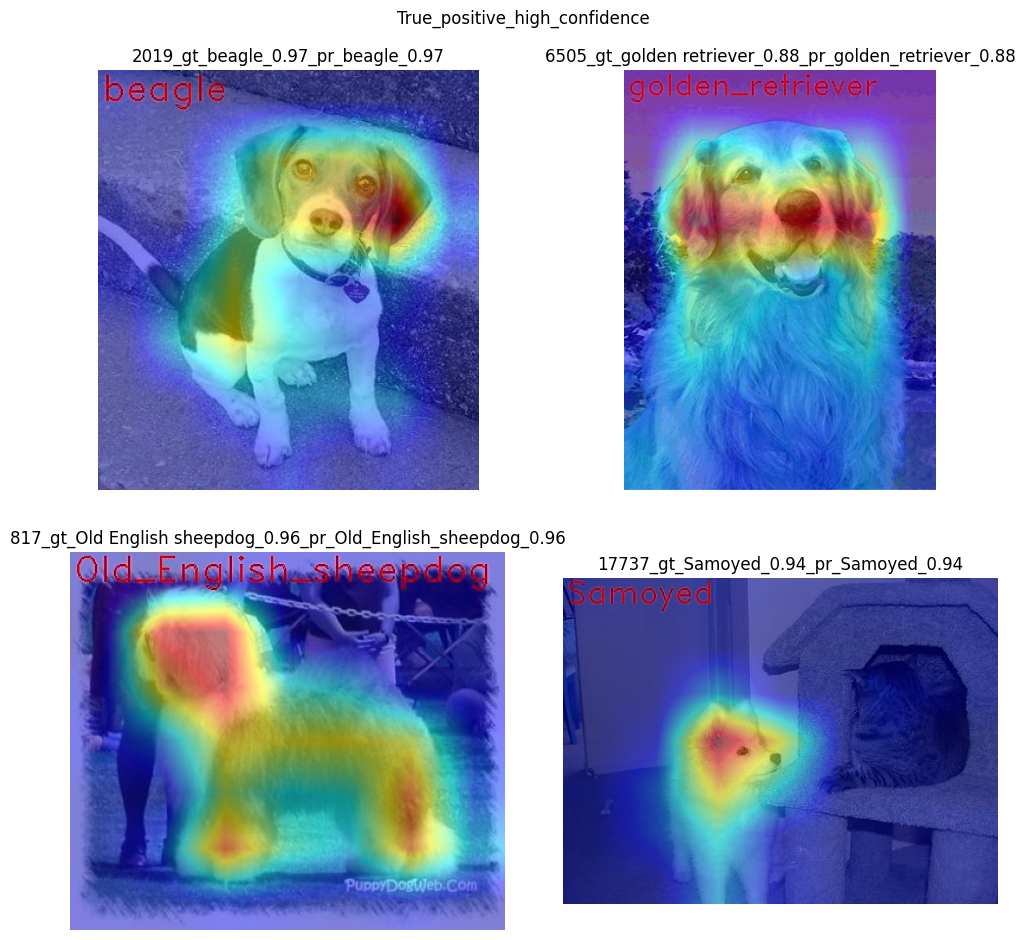

In [22]:
show_use_case_image("True_positive_high_confidence")

In the case of `True positive high confidence`, the model predicts the correct class and is confident about its prediction.

The saliency map highlights features that strongly contribute to the correct class, meaning that those features are very salient for the current class. We want to roughly estimate that the highlighted features are correct. From the above images, we see that the dog's face, nose, ears, and the general shape of the dog's body usually contain the strongest features for the model. That correlates with our common knowledge and points to the fact that the model is well-trained and focuses on the needed areas.

Another sign that the model learns the right features is that the classes are well distinguished by the model. Cat features are not used at all to predict `Samoyed` in image `17737`, which is the desired behavior.

### True Positive Low confidence
[back to top ⬆️](#Table-of-contents:)

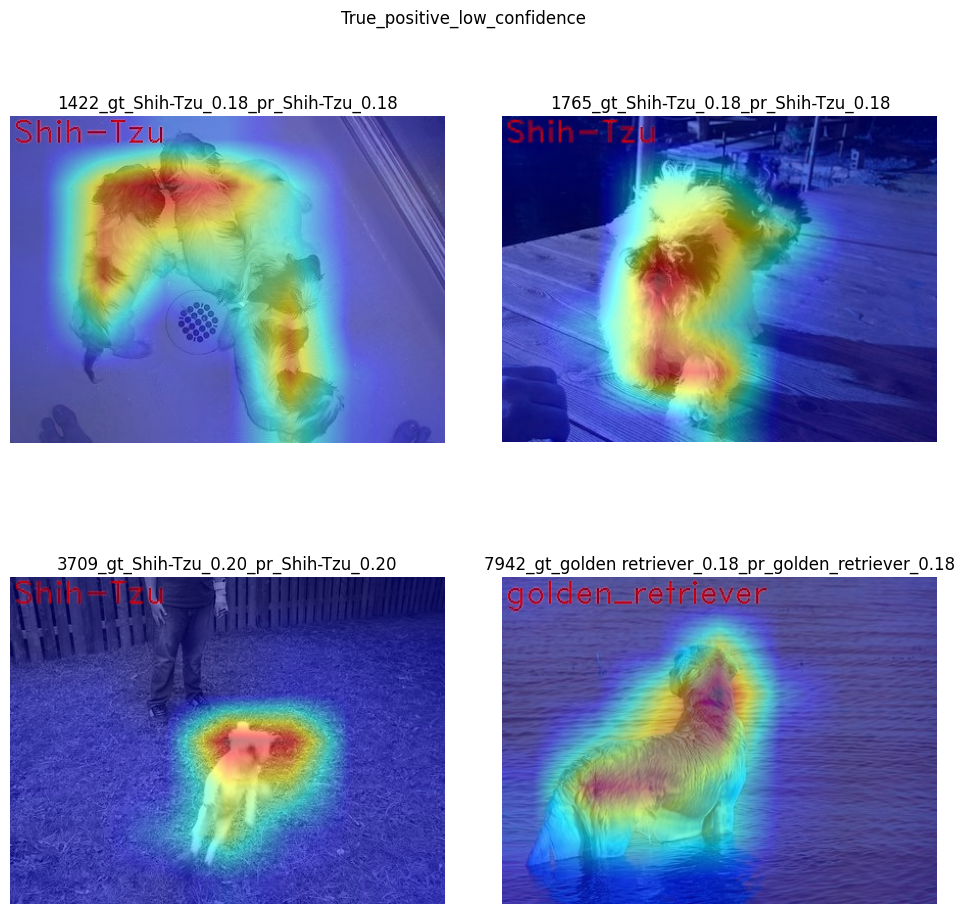

In [23]:
show_use_case_image("True_positive_low_confidence")

`True positive low confidence` basically means that key features are not well available or are transformed. From the saliency maps, we see that the model is paying attention to the whole object, trying to make a decision mostly based on high-level features.

### False Positive High confidence
[back to top ⬆️](#Table-of-contents:)


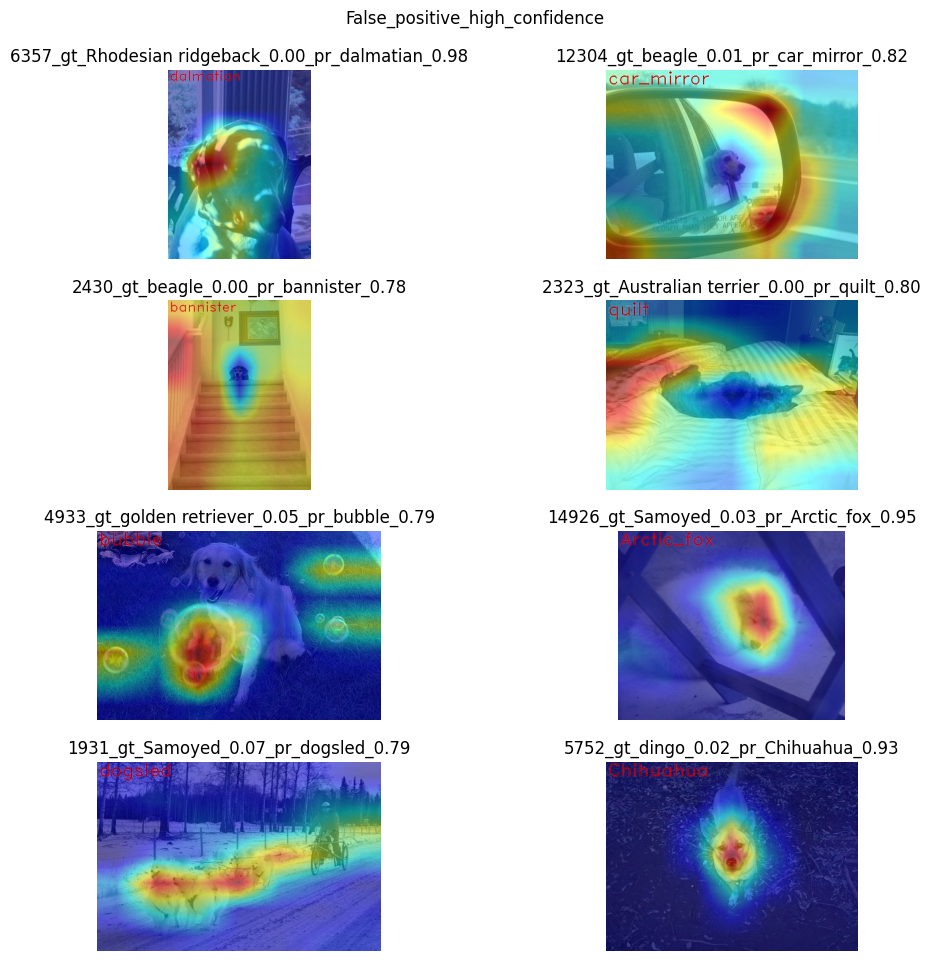

In [24]:
show_use_case_image("False_positive_high_confidence")

Here we see a few different reasons why the model can predict one class instead of another:

- There are objects of two classes represented in the image, and one class is much more obvious than the other. For example, it's larger or in the foreground.
  We can see this in the image `2430` (`bannister` instead of `beagle`), `1931` (`dogsled` instead of `samoyed`), `2323` (`quilt` instead of `Australian terrier`), `12304` (`car mirror` instead of `beagle`).

  We can see that it's not the problem of the model but rather the characteristic of the picture itself. 
  In multiclass classification with only one annotated class in the image (and softmax applied to the model), this can happen if features of the wrong class dominate the features of the right class. Also, this might indicate a labeling error.

- Two classes look similar in specific shooting settings.

  In the picture `5752`, the big `dingo` dog was confused with a small `chihuahua`, focusing only on the face features. In the picture `14926`, a sleeping `samoyed` was confused with an `arctic fox` because the sleeping position distorted the key features, making the classes look even more alike than usual. In the picture `6357`, shadows created a pattern on the dog, so the model found key features for the `dalmatian` class and predicted it with high confidence.

As a result, we see that the model is well-trained and mixes classes only because of intricate shooting conditions and the presence of more than one class in the picture.

### Two mixed predictions
[back to top ⬆️](#Table-of-contents:)


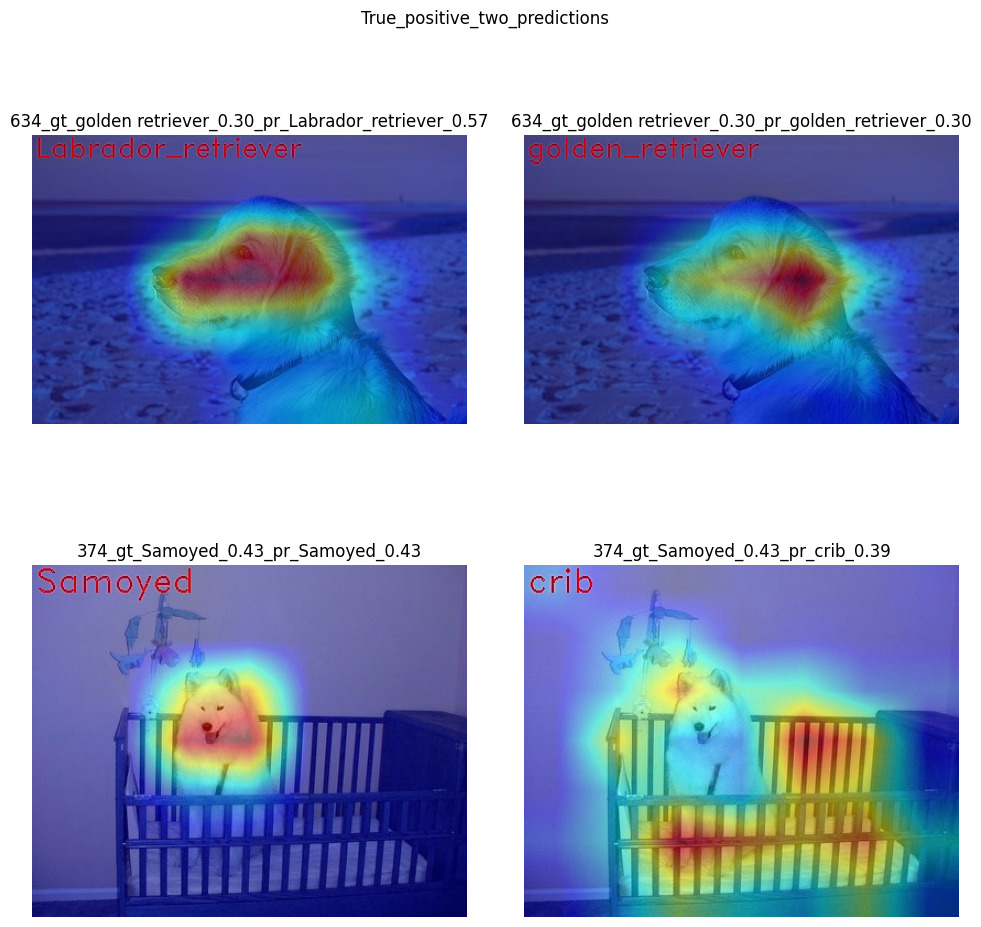

In [25]:
show_use_case_image("True_positive_two_predictions")

Here are examples where two classes are predicted with relatively high confidence, and the model is sure about both of them. We can see how saliency maps are different for each class.

In the  picture `634`, the model can't decide between `golden retriever` and `labrador`, focusing on the whole face shape.

In the image `374`, both `samoyed` and `crib` are well-seen, so the model cannot decide between these two classes. We clearly see the different areas of interest for each of these classes.